In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')   
    

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Model
print('==> Loading model..')
net = VGG('VGG19')
# net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
# net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
print('==> Resuming from checkpoint..')
assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./checkpoint/VGG19.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()

==> Loading model..
==> Resuming from checkpoint..


In [4]:
def test():
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [5]:
test()

Loss: 0.297 | Acc: 93.850% (9385/10000)


In [17]:
def output_label(label):
    output_mapping = {
                 0: "plane",
                 1: "car",
                 2: "bird",
                 3: "cat",
                 4: "deer", 
                 5: "dog", 
                 6: "frog",
                 7: "horse",
                 8: "ship",
                 9: "truck"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [22]:
ex_loader = torch.utils.data.DataLoader(trainset, batch_size=10)

ex_batch = next(iter(ex_loader))
ex_images, ex_labels = ex_batch
print(type(ex_images), type(ex_labels))
print(ex_images.shape, ex_labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 3, 32, 32]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  frog, truck, truck, deer, car, car, bird, horse, ship, cat, 

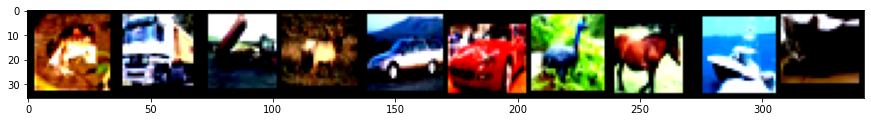

In [23]:
grid = torchvision.utils.make_grid(ex_images/ 2 + 0.5, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(ex_labels):
    print(output_label(label), end=", ")

In [69]:
sample_idx = 4
ex_img = ex_images[sample_idx]
outputs = net(ex_img.unsqueeze(0))
output_probs = F.softmax(outputs, dim=1).squeeze(0)
label_idx = output_probs.argmax().unsqueeze(0)

if output_label(label_idx) == output_label(ex_labels[sample_idx]):
    print("Correct prediction: ", output_label(label_idx))
else:
    print("Incorrect prediction.")

Correct prediction:  car


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SLIC number of segments: 7


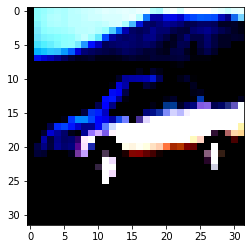

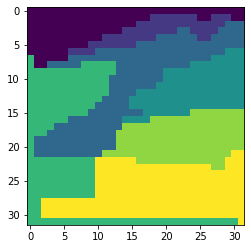

In [72]:
from skimage.segmentation import slic, quickshift
from skimage.segmentation import mark_boundaries

def segment_img(torch_img, n_segments=10, compactness=2, sigma=1, start_label=0):
    np_img = torch_img.numpy()
    np_img = np.swapaxes(np_img,0,1)
    np_img = np.swapaxes(np_img,1,2)
    segments_slic = slic(np_img, n_segments=n_segments, compactness=compactness,
                         sigma=sigma, start_label=start_label)
    return np_img, segments_slic

np_img, segments_slic = segment_img(ex_img,n_segments=10, compactness=2, sigma=1)
plt.imshow(np_img)
plt.figure()
plt.imshow(segments_slic)
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
feature_mask = torch.from_numpy(segments_slic)


In [6]:
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

In [104]:
from torch import Tensor

def default_perturb_func(original_inp, **kwargs):
    assert (
        "num_interp_features" in kwargs
    ), "Must provide num_interp_features to use default interpretable sampling function"
    if isinstance(original_inp, Tensor):
        device = original_inp.device
    else:
        device = original_inp[0].device

    probs = torch.ones(1, kwargs["num_interp_features"]) * 0.5
    return torch.bernoulli(probs).to(device=device).long()

In [105]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    net, 
    interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance,
    perturb_func = default_perturb_func
)

In [110]:
default_perturb_func(ex_img.unsqueeze(0), num_interp_features  = len(np.unique(segments_slic)))

tensor([[0, 0, 0, 1, 1, 1, 1]])

In [117]:
attrs = lr_lime.attribute(
    ex_img.unsqueeze(0),
    target=label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=20000,
    perturbations_per_eval=1000,
    show_progress=True
).squeeze(0)

Lime attribution: 100%|█████████████████████████| 20/20 [00:03<00:00,  5.10it/s]


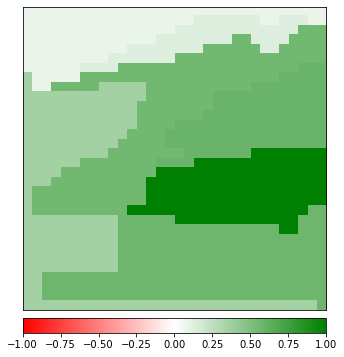

In [118]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
    
show_attr(attrs)

In [97]:
attrs.shape

torch.Size([3, 32, 32])